# PoS Tagger

## Setup de ambiente

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from typing import List, Tuple
import seaborn as sns

## Dados

In [3]:
train_file = "Penn Treebank/Secs0-18 - training"
dev_file   = "Penn Treebank/Secs19-21 - development"
test_file  = "Penn Treebank/Secs22-24 - testing"

## Preprocessamento

In [ ]:
def carregar_corpus(caminho_arquivo: str) -> str:
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        return f.read()
    
def dividir_em_sentencas(texto: str) -> List[str]:
    return texto.strip().split("\n")

def processar_sentenca(sentenca: str) -> List[Tuple[str, str]]:
    tokens = sentenca.strip().split()
    pares = []
    for token in tokens:
        if "_" in token:
            palavra, tag = token.rsplit("_", 1)
            if not(tag == 'NNP' or tag == 'NNPS'):
                palavra = palavra.lower()
            pares.append((palavra, tag))
    return pares

def construir_dataframe(sentencas: List[str]) -> pd.DataFrame:
    dados = []

    for sent_id, sentenca in enumerate(sentencas):
        palavras_tags = processar_sentenca(sentenca)
        for posicao, (palavra, tag) in enumerate(palavras_tags):
            dados.append({
                "sentenca": sent_id + 1,
                "palavra": palavra,
                "tag": tag,
                "posicao_na_sentenca": posicao
            })

    return pd.DataFrame(dados)

In [ ]:
texto_raw_train = carregar_corpus(train_file)
sentencas_train = dividir_em_sentencas(texto_raw_train)
df_treino = construir_dataframe(sentencas_train)

texto_raw_dev = carregar_corpus(dev_file)
texto_raw_teste = carregar_corpus(test_file)
sentencas_teste = dividir_em_sentencas(texto_raw_dev + texto_raw_teste)
df_teste = construir_dataframe(sentencas_teste)

df_treino

,sentenca,palavra,tag,posicao_na_sentenca
0,1,Pierre,NNP,0
1,1,Vinken,NNP,1
2,1,",",",",2
3,1,61,CD,3
4,1,years,NNS,4
...,...,...,...,...
912339,38219,to,TO,21
912340,38219,San,NNP,22
912341,38219,Francisco,NNP,23
912342,38219,instead,RB,24


## Treino de POS Tagging

In [6]:
from collections import defaultdict, Counter

def treinar_baseline_unigrama(df_treino: pd.DataFrame) -> dict:
    """
    Mapeia cada palavra para sua tag mais frequente no treino.
    """
    tag_frequente = df_treino.groupby("palavra")["tag"].agg(lambda x: Counter(x).most_common(1)[0][0])
    return tag_frequente.to_dict()

# def prever_baseline(df_teste: pd.DataFrame, modelo_unigrama: dict, default_tag="NN") -> List[str]:
#     """
#     Prediz tags com base no mapeamento unigrama. Para palavras desconhecidas, usa default_tag.
#     """
#     return [modelo_unigrama.get(palavra, default_tag) for palavra in df_teste["palavra"]]

SUFIXO_TAG = {
    "ing":  "VBG",
    "ed":   "VBD",
    "ion":  "NN",
    "s":    "NNS",
    "es":   "VBZ",
    "ly":   "RB",
    "al":   "JJ",
}

def tag_por_sufixo(palavra: str, default="NN"):
    for k,v in SUFIXO_TAG.items():
        if palavra.lower().endswith(k):
            return v
    if palavra[0].isupper():
        return "NNP"
    if palavra.isdigit():
        return "CD"
    return default

def prever_baseline(df: pd.DataFrame, modelo_uni: dict,
                     default_tag="NN") -> List[str]:
    y_pred = []
    for w in df["palavra"]:
        tag = modelo_uni.get(w)
        if tag is None:
            tag = tag_por_sufixo(w, default_tag)
        y_pred.append(tag)
    return y_pred

In [7]:
from sklearn.metrics import accuracy_score

def avaliar_acuracia(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calcula acurácia ignorando pontuações e BOS/EOS.
    """
    validas = [(real, pred) for real, pred in zip(y_true, y_pred) if real not in {".", ",", ":", "``", "''", "(", ")", "-NONE-", "BOS", "EOS"}]
    y_true_filtrado, y_pred_filtrado = zip(*validas)
    return accuracy_score(y_true_filtrado, y_pred_filtrado)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def mostrar_matriz_confusao(y_true: List[str], y_pred: List[str]):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(30, 30))
    disp.plot(ax=ax, xticks_rotation=90)
    plt.title("Matriz de Confusão - POS Tagger")
    plt.show()

## Avaliação do modelo

Tags previstas: ['JJ', 'NNS', 'IN', 'DT', 'NNP', 'NNPS', 'CC', 'NNP', 'NNP', 'VBN', 'NN', 'IN', 'MD', 'VB', 'WRB', 'DT', 'JJ', 'JJ', 'NN', 'NN', 'MD', 'VB', 'NN', ',', 'VBG', 'DT', 'JJ', 'NN', 'TO', 'DT', 'NN', 'POS', 'NN', 'IN', 'JJ', 'NNS', '.', 'DT', 'NN', ',', 'WP$', 'NNS', 'VBP', 'NNP', 'NNP', 'NNP', '-LRB-', 'NNP', ',', 'NNP', '-RRB-', ',', 'MD', 'VB', 'DT', 'NNP', 'NNP', 'NNP', 'IN', 'VBG', 'JJ', 'VBG', 'NN', 'IN', 'VBG', 'DT', 'VBD', 'NN', 'CC', 'NN', 'NN', 'NN', 'IN', 'MD', 'RB', 'VB', 'VBN', 'IN', 'DT', 'JJ', 'NN', '.', 'DT', 'NN', 'VBZ', 'TO', 'VB', 'DT', 'NNP', 'TO', 'NNP', 'NNS', 'RB', ',', 'IN', 'DT', 'NN', 'VBZ', 'JJ', 'JJ', 'NN', '.', '``', 'JJ', 'NN', '``', 'NN', 'POS', 'NN', 'VBZ', 'JJ', 'CC', 'JJ', ',', 'RB', 'JJR', 'JJ', 'IN', 'JJ', 'NNP', 'NN', ',', "''", 'VBD', 'NNP', 'NNP', 'NNP', '-LRB-', 'NNP', ',', 'NNP', '-RRB-', ',', 'DT', 'NN', 'POS', 'JJ', 'NN', '.', 'DT', 'JJ', 'NN', 'NN', 'IN', 'DT', 'NN', 'NN', 'NN', 'VBZ', 'VBG', '$', 'CD', 'CD', 'IN', 'NN', 'VBN', 'IN

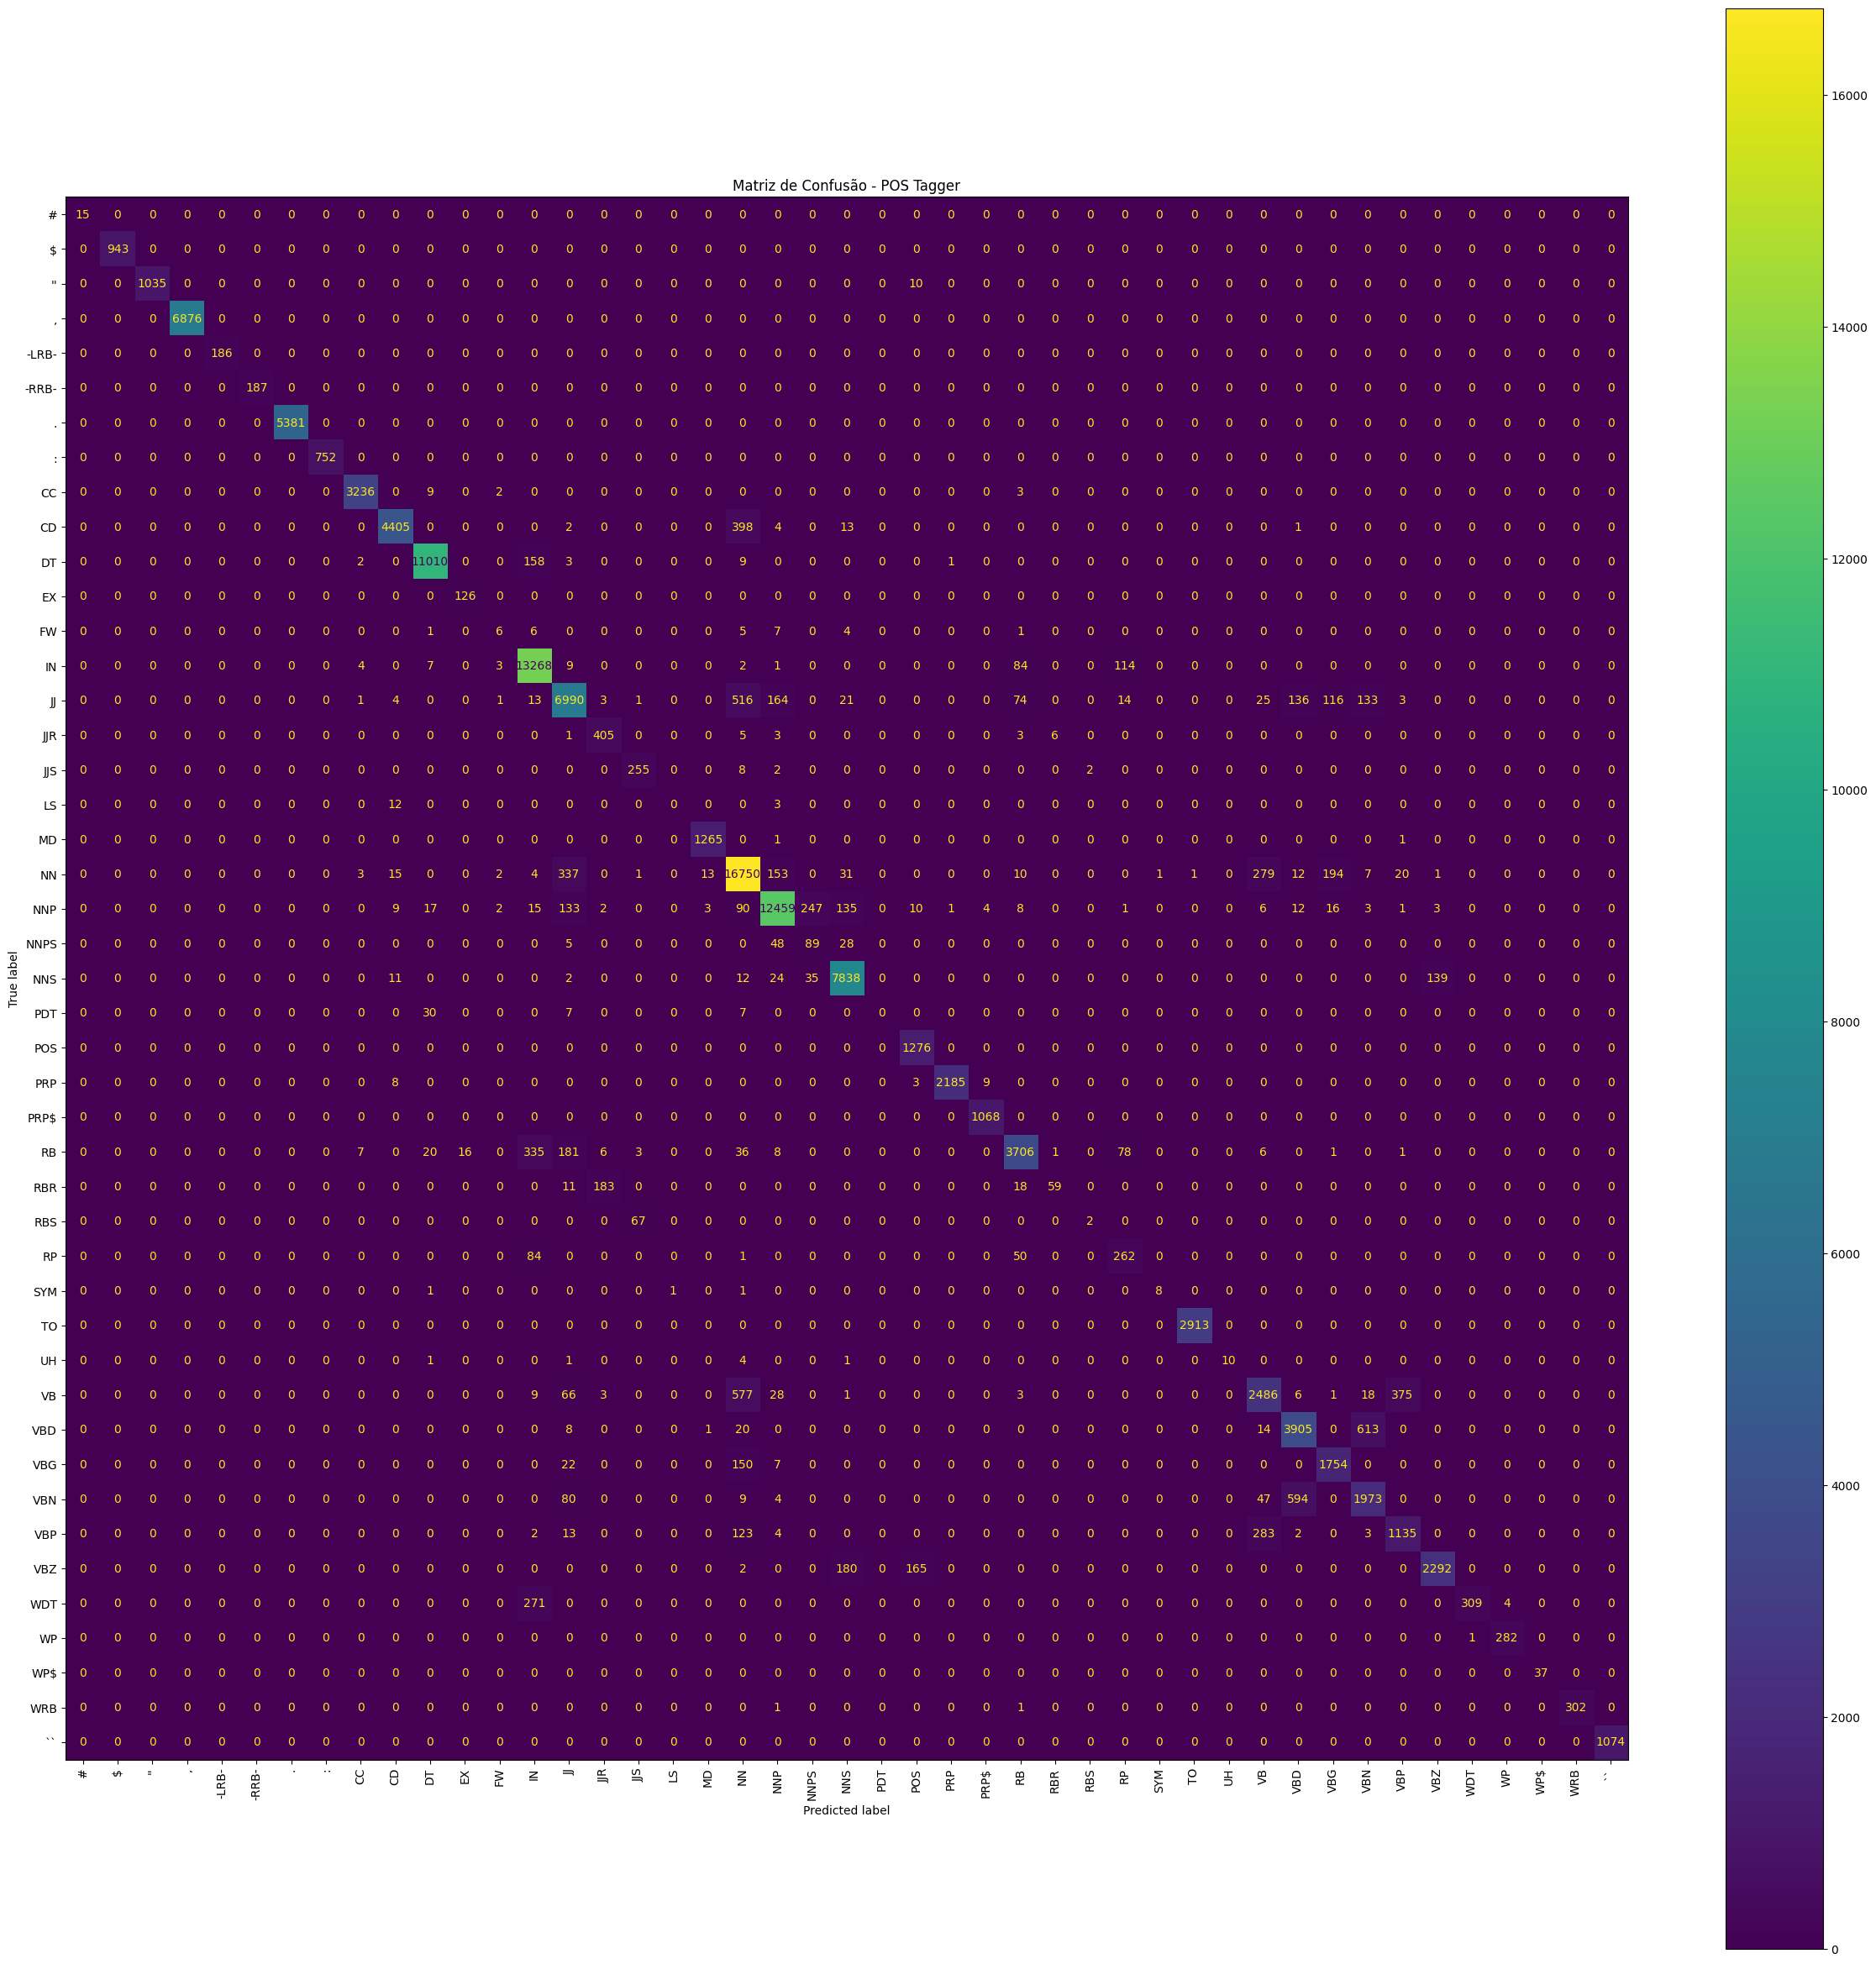

In [9]:
modelo_unigrama = treinar_baseline_unigrama(df_treino)
y_pred = prever_baseline(df_teste, modelo_unigrama, default_tag="NN")
y_true = df_teste["tag"].tolist()

acuracia_unigrama = avaliar_acuracia(y_true, y_pred)
print("Tags previstas:", y_pred)
print("Tags reais:    ", y_true)
print("Acurácia:", acuracia_unigrama)

mostrar_matriz_confusao(y_true, y_pred)

# Bigrama

In [10]:
from collections import defaultdict, Counter
from typing import List

In [11]:
# Treinamento
def treinar_modelo_bigramas(df):
    sentencas_tags = df.groupby('sentenca')['tag'].apply(list).tolist()

    bigramas_tag = Counter()
    unigramas_tag = Counter()

    for tags in sentencas_tags:
        tags = ['<s>'] + tags
        unigramas_tag.update(tags)
        bigramas_tag.update(zip(tags[:-1], tags[1:]))

    prob_bigramas = defaultdict(lambda: defaultdict(float))

    for (tag_anterior, tag_atual), count in bigramas_tag.items():
        prob_bigramas[tag_anterior][tag_atual] = count / unigramas_tag[tag_anterior]

    palavra_tag_counts = Counter(zip(df['palavra'], df['tag']))
    tag_counts = Counter(df['tag'])

    prob_emissao = defaultdict(lambda: defaultdict(float))

    for (palavra, tag), count in palavra_tag_counts.items():
        prob_emissao[tag][palavra] = count / tag_counts[tag]

    vocab = set(df['palavra'].unique())
    vocab.add('<UNK>')

    return prob_bigramas, prob_emissao, unigramas_tag, vocab

In [12]:
# Predição
def prever_bigram_com_sufixo(df: pd.DataFrame, modelo, default_tag='NN') -> List[str]:
    prob_bigramas, prob_emissao, unigramas_tag, vocab = modelo

    y_pred = []
    tag_anterior = '<s>'

    for palavra in df["palavra"]:
        palavra_proc = palavra if palavra in vocab else '<UNK>'

        max_prob = 0
        melhor_tag = None

        for tag in unigramas_tag:
            prob_transicao = prob_bigramas[tag_anterior].get(tag, 0)
            prob_emitir = prob_emissao[tag].get(palavra_proc, 0)
            prob_total = prob_transicao * prob_emitir

            if prob_total > max_prob:
                max_prob = prob_total
                melhor_tag = tag

        # Se palavra desconhecida ou probabilidade zero, usa sufixo
        if palavra_proc == '<UNK>' or max_prob == 0:
            melhor_tag = tag_por_sufixo(palavra, default_tag)

        y_pred.append(melhor_tag)
        tag_anterior = melhor_tag

    return y_pred


In [13]:
# Avaliação
def avaliar_acuracia(y_true: List[str], y_pred: List[str]) -> float:
    validas = [
        (real, pred) for real, pred in zip(y_true, y_pred)
        if real not in {".", ",", ":", "``", "''", "(", ")", "-NONE-", "BOS", "EOS"}
    ]
    y_true_filtrado, y_pred_filtrado = zip(*validas)
    return accuracy_score(y_true_filtrado, y_pred_filtrado)


Acurácia do modelo Bigram+Sufixo: 0.9376


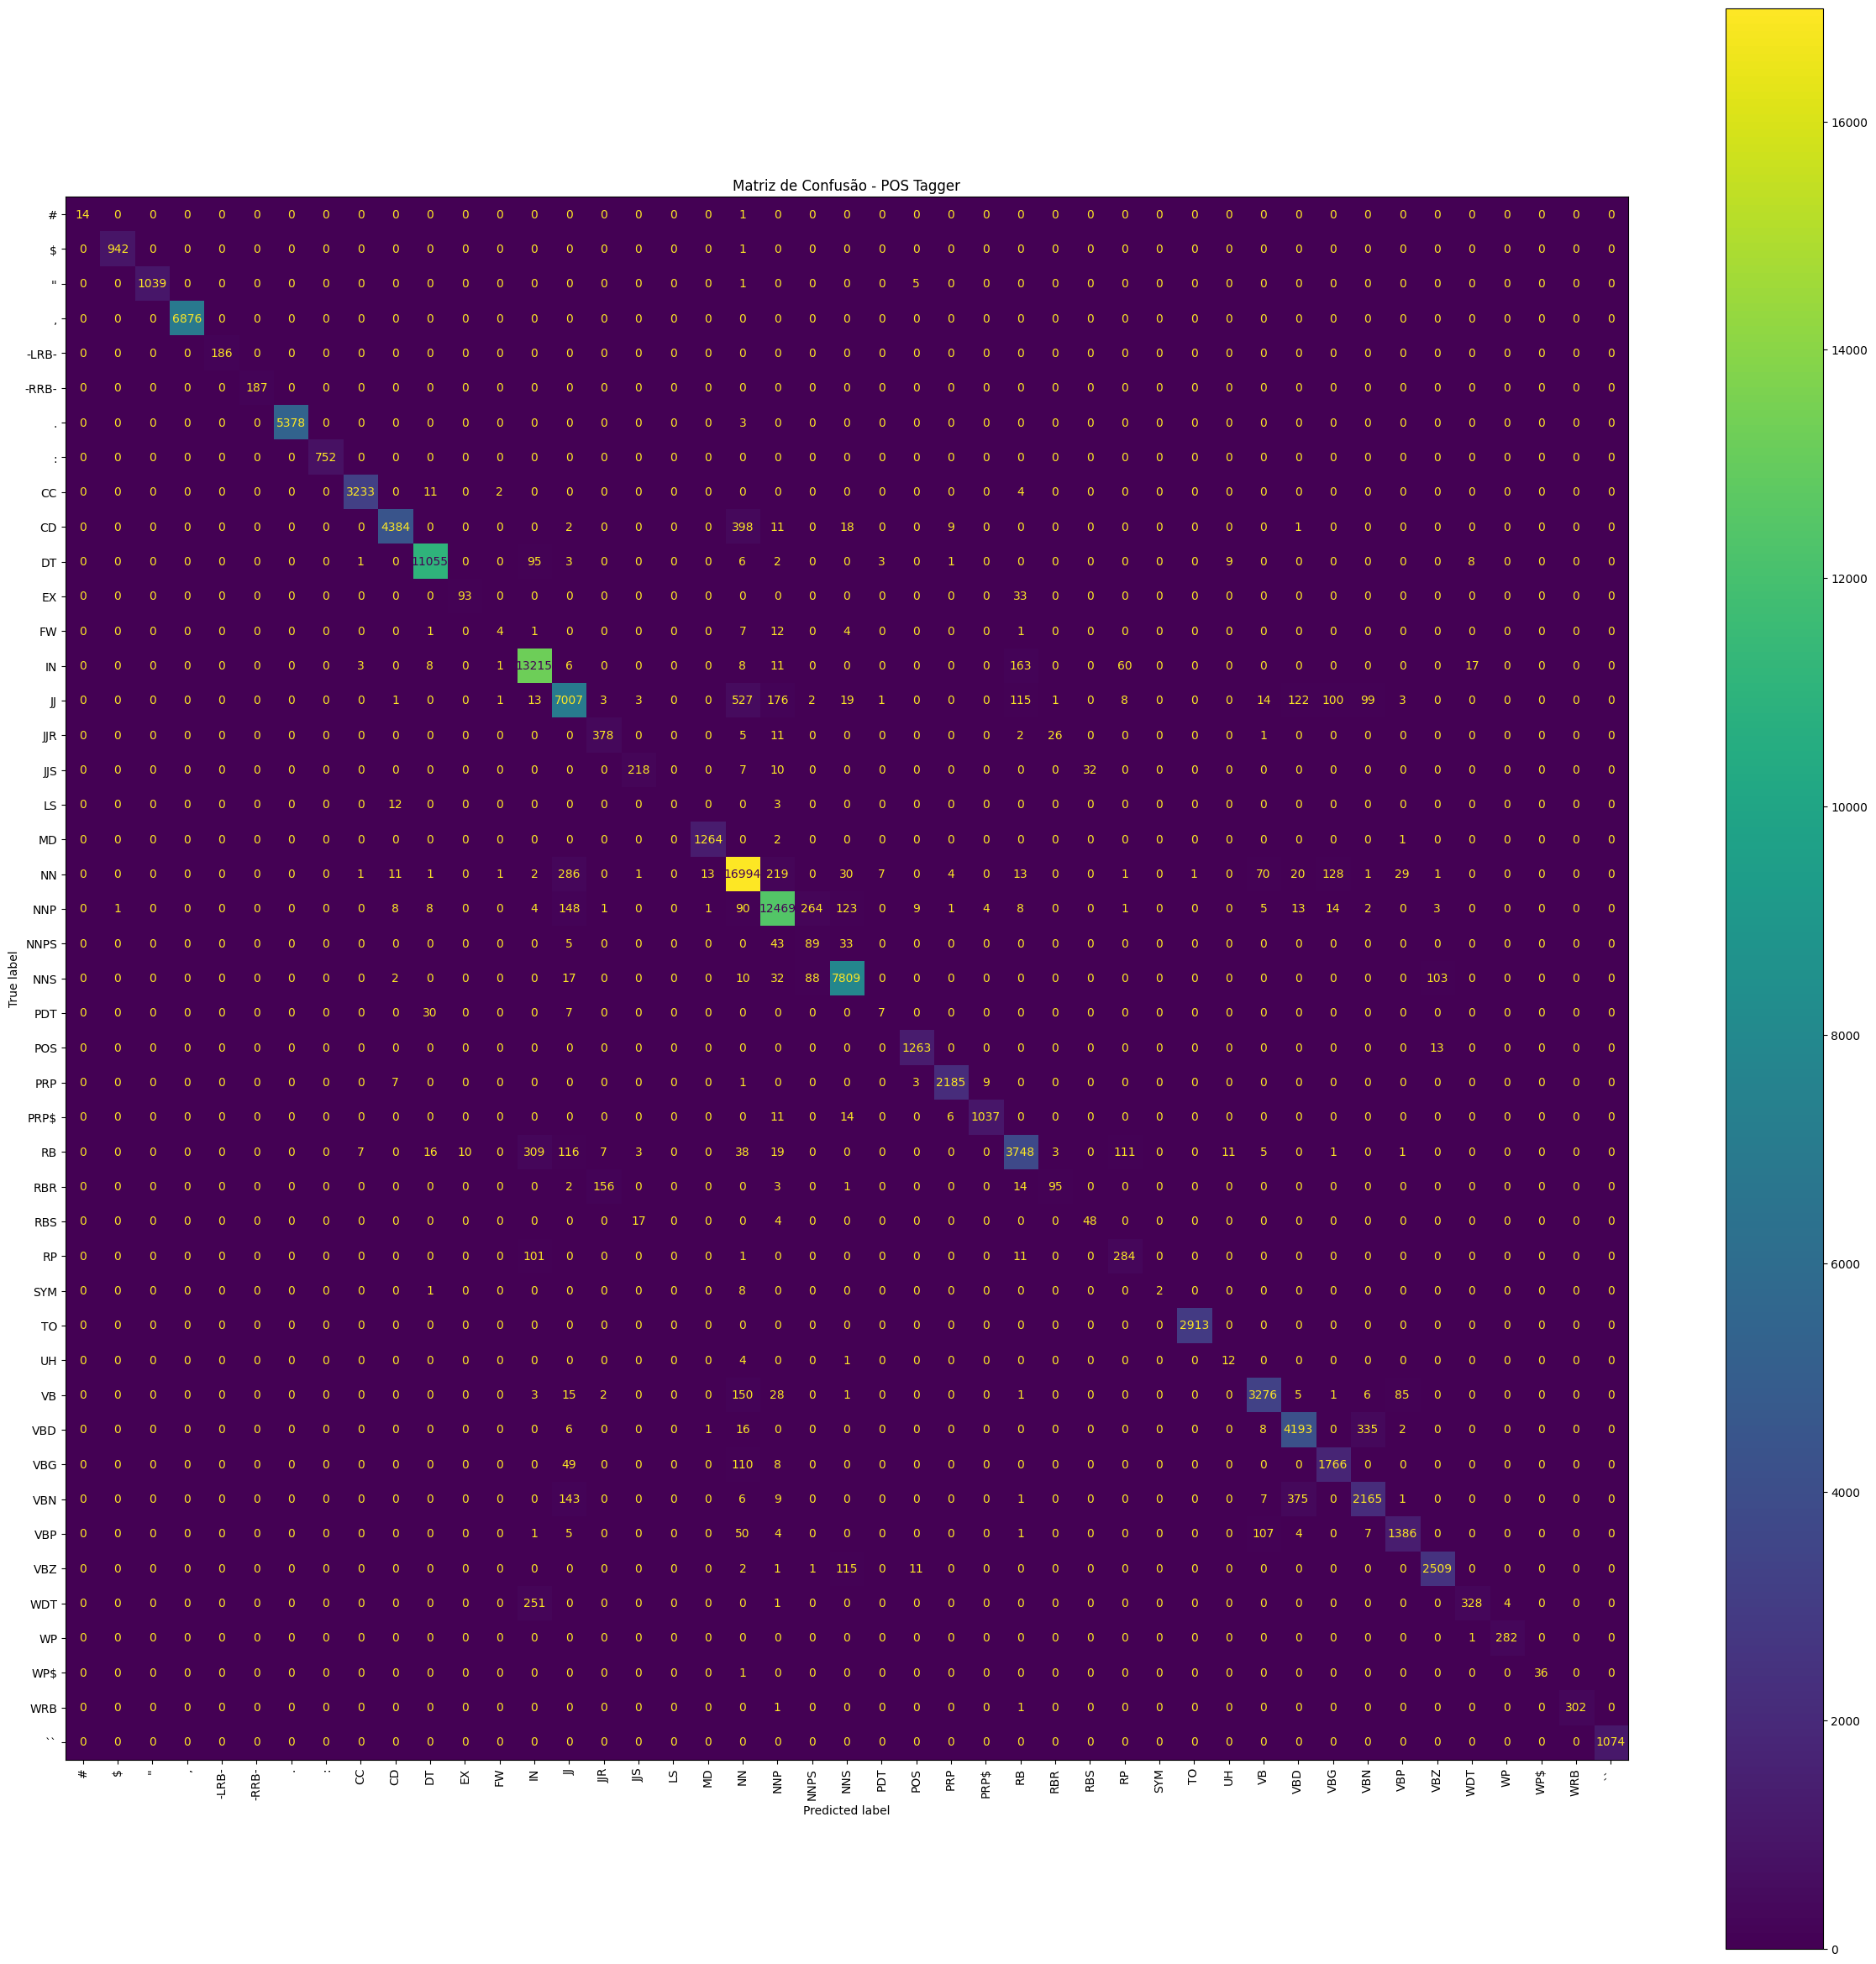

In [14]:
# Treinando o modelo com dataset de treino
modelo = treinar_modelo_bigramas(df_treino)

y_pred = prever_bigram_com_sufixo(df_teste, modelo)
y_true = df_teste["tag"].tolist()

acuracia = avaliar_acuracia(df_teste["tag"].tolist(), y_pred)
print(f"Acurácia do modelo Bigram+Sufixo: {acuracia:.4f}")

# Plotar a matriz de confusão
mostrar_matriz_confusao(y_true, y_pred)

# Trigrama


In [15]:
def treinar_modelo_trigramas(df):
    sentencas_tags = df.groupby('sentenca')['tag'].apply(list).tolist()

    trigramas_tag = Counter()
    bigramas_tag = Counter()

    for tags in sentencas_tags:
        tags = ['<s>', '<s>'] + tags  # dois símbolos para início
        trigramas_tag.update(zip(tags[:-2], tags[1:-1], tags[2:]))
        bigramas_tag.update(zip(tags[:-2], tags[1:-1]))

    prob_trigramas = defaultdict(lambda: defaultdict(float))

    for (t1, t2, t3), count in trigramas_tag.items():
        prob_trigramas[(t1, t2)][t3] = count / bigramas_tag[(t1, t2)]

    palavra_tag_counts = Counter(zip(df['palavra'], df['tag']))
    tag_counts = Counter(df['tag'])

    prob_emissao = defaultdict(lambda: defaultdict(float))

    for (palavra, tag), count in palavra_tag_counts.items():
        prob_emissao[tag][palavra] = count / tag_counts[tag]

    vocab = set(df['palavra'].unique())
    vocab.add('<UNK>')

    tags_unicas = set(df['tag'])

    return prob_trigramas, prob_emissao, tags_unicas, vocab


In [16]:
def prever_trigram_com_sufixo(df: pd.DataFrame, modelo, default_tag='NN') -> List[str]:
    prob_trigramas, prob_emissao, tags_unicas, vocab = modelo

    y_pred = []
    tag_anterior1, tag_anterior2 = '<s>', '<s>'

    for palavra in df["palavra"]:
        palavra_proc = palavra if palavra in vocab else '<UNK>'

        max_prob = 0
        melhor_tag = None

        for tag in tags_unicas:
            prob_transicao = prob_trigramas[(tag_anterior2, tag_anterior1)].get(tag, 0)
            prob_emitir = prob_emissao[tag].get(palavra_proc, 0)
            prob_total = prob_transicao * prob_emitir

            if prob_total > max_prob:
                max_prob = prob_total
                melhor_tag = tag

        # fallback para sufixos
        if palavra_proc == '<UNK>' or max_prob == 0:
            melhor_tag = tag_por_sufixo(palavra, default_tag)

        y_pred.append(melhor_tag)
        tag_anterior2, tag_anterior1 = tag_anterior1, melhor_tag

    return y_pred


In [17]:
def avaliar_acuracia(y_true: List[str], y_pred: List[str]) -> float:
    validas = [
        (real, pred) for real, pred in zip(y_true, y_pred)
        if real not in {".", ",", ":", "``", "''", "(", ")", "-NONE-", "BOS", "EOS"}
    ]
    y_true_filtrado, y_pred_filtrado = zip(*validas)
    return accuracy_score(y_true_filtrado, y_pred_filtrado)

Acurácia do modelo Trigram+Sufixo: 0.8980


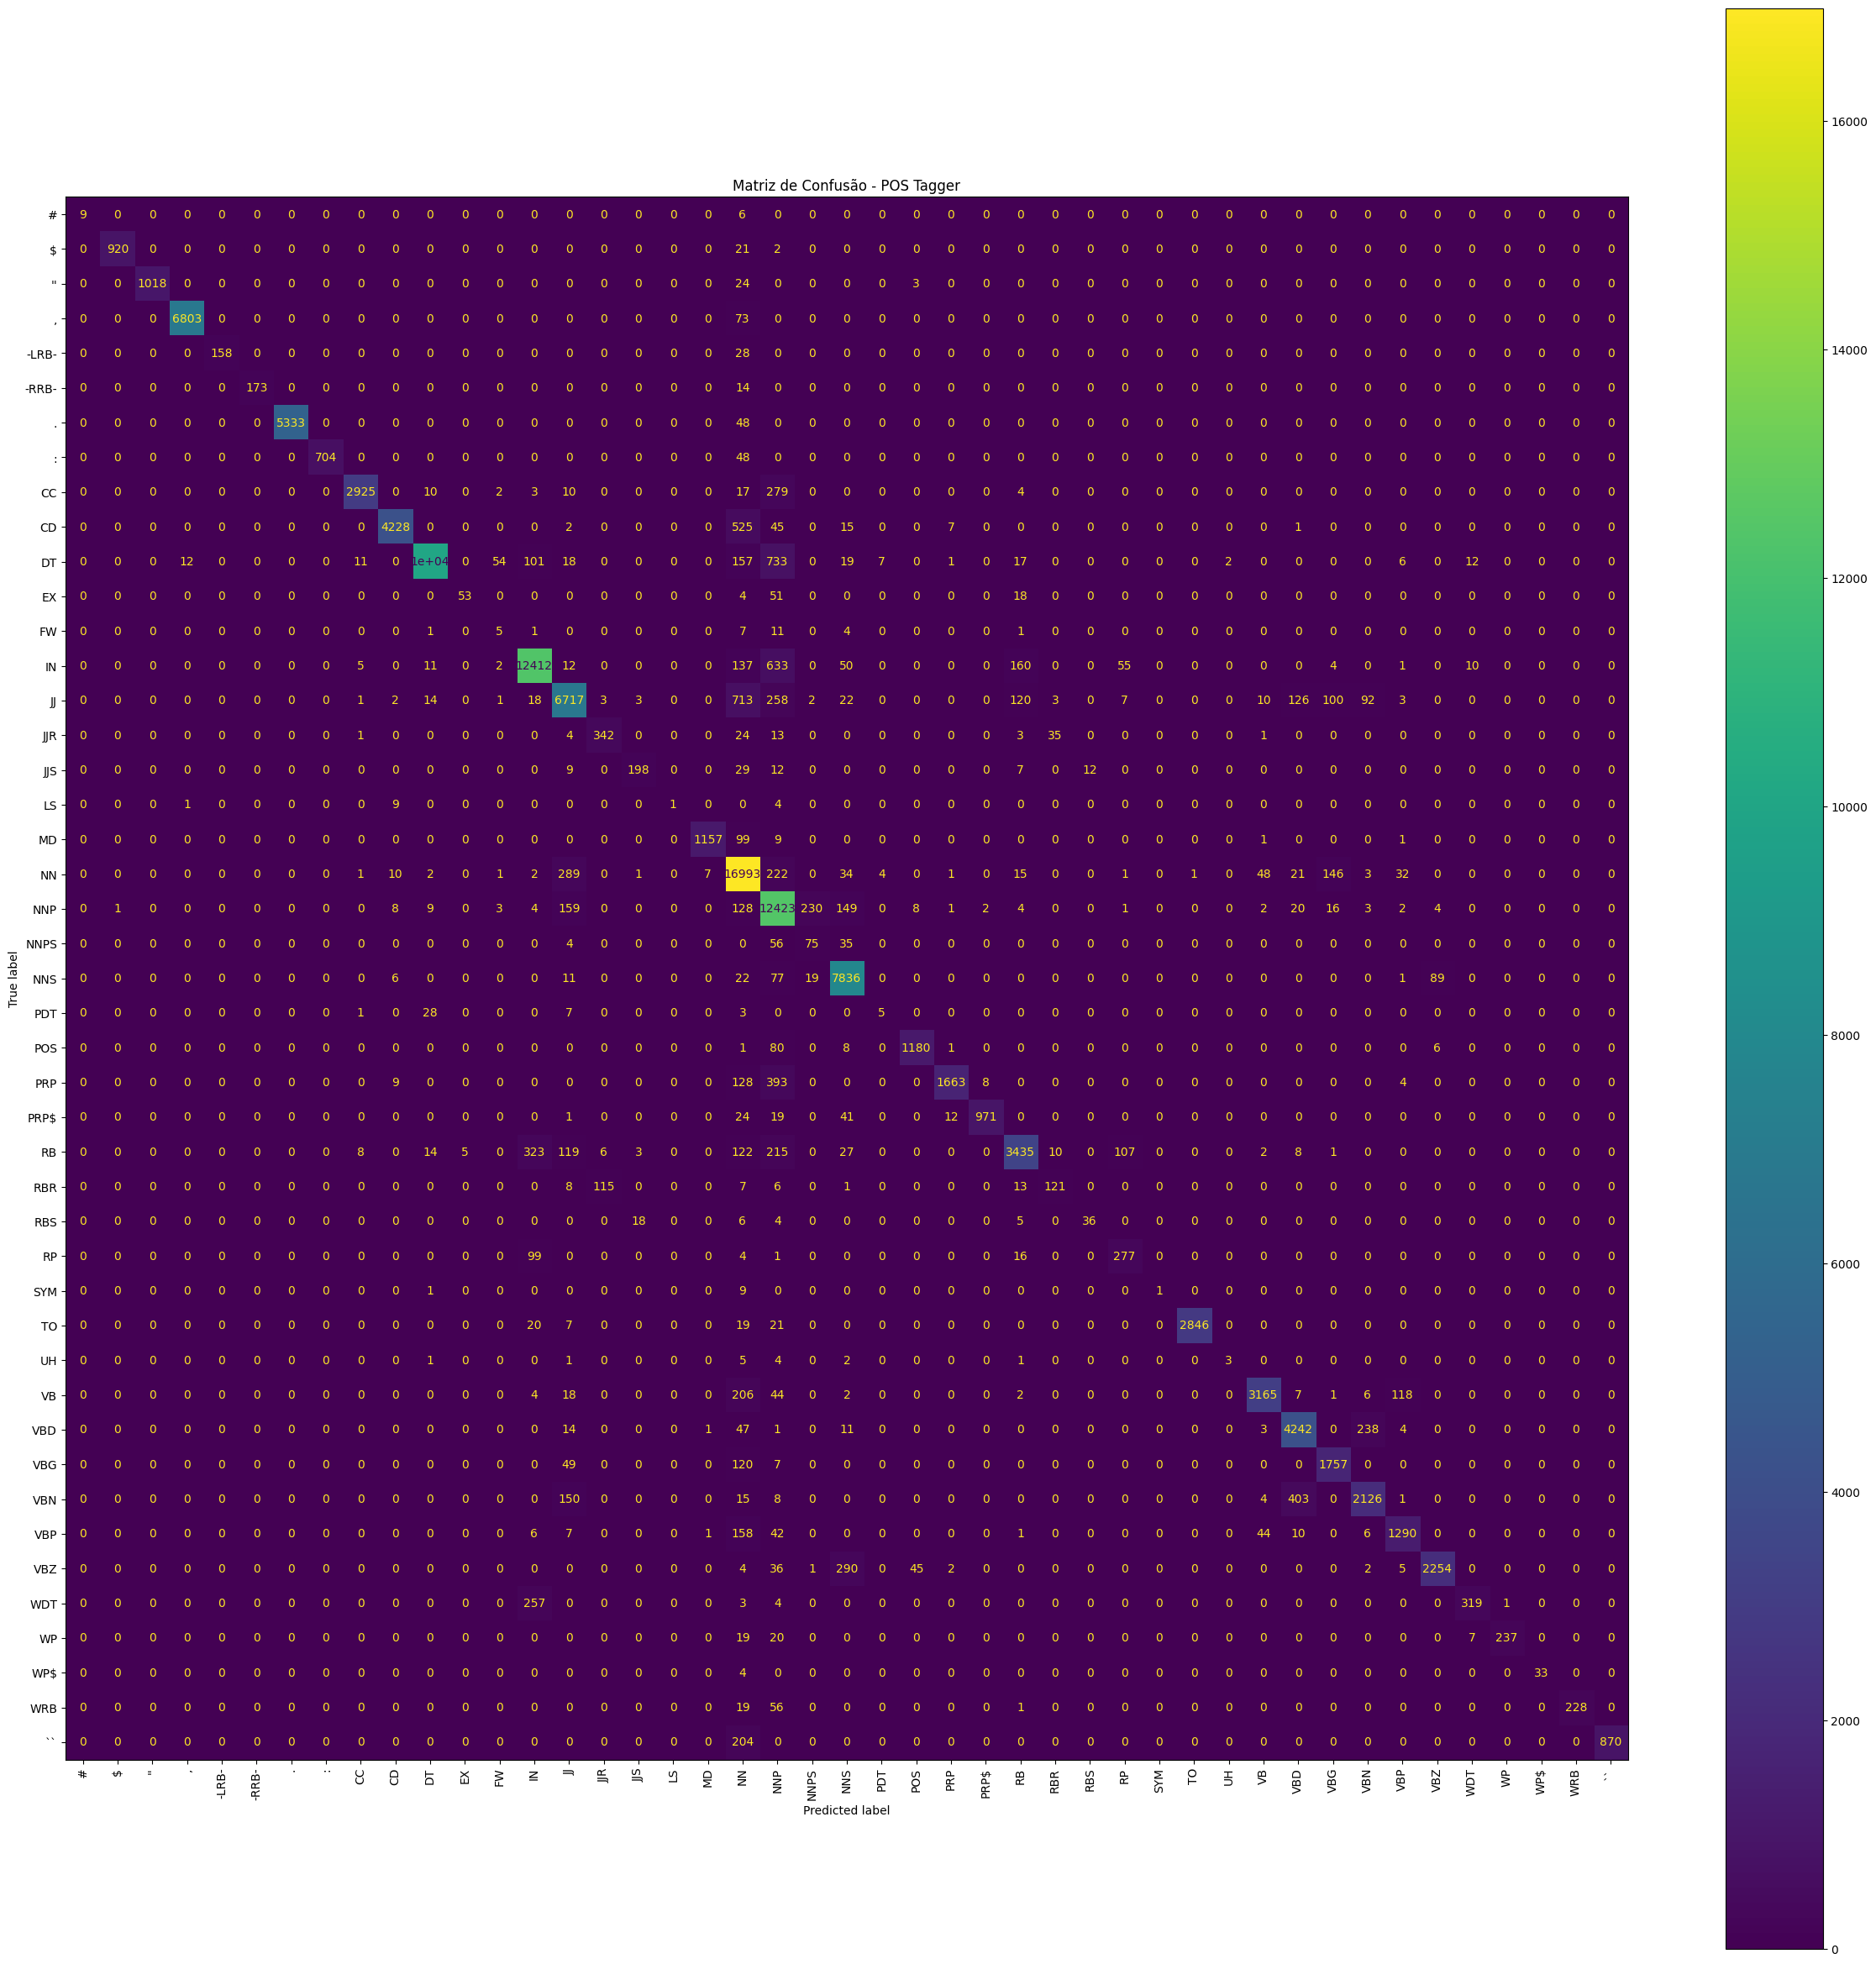

In [18]:
# Treinando o modelo de trigramas
modelo_trigram = treinar_modelo_trigramas(df_treino)

# Previsão no dataset de teste usando trigram+sufixo
y_pred_trigram = prever_trigram_com_sufixo(df_teste, modelo_trigram)

# Avaliando o modelo trigrama
acuracia_trigram = avaliar_acuracia(df_teste["tag"].tolist(), y_pred_trigram)
print(f"Acurácia do modelo Trigram+Sufixo: {acuracia_trigram:.4f}")

# Matriz de confusão
mostrar_matriz_confusao(df_teste["tag"].tolist(), y_pred_trigram)
